In [1]:
import cmath
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from qutip import qeye, propagator, tensor, Qobj, sesolve, basis, sigmax, sigmay, sigmaz, Options

In [2]:
ZA = tensor(sigmaz(), qeye(2))
ZB = tensor(qeye(2), sigmaz())

sqrt2 = np.sqrt(2.0)
sqrtiSWAP = np.array([[1.0, 0.0, 0.0, 0.0],
                      [0.0, 1/sqrt2, -1j/sqrt2, 0.0],
                      [0.0, -1j/sqrt2, 1/sqrt2, 0.0],
                      [0.0, 0.0, 0.0, 1.0]])
sqrtiSWAP_Q = Qobj(sqrtiSWAP)

H_0_ = np.genfromtxt('H_0.txt')
XX_ = np.genfromtxt('XX.txt')
H_0 = Qobj(H_0_)
XX = Qobj(XX_)
omega_a = np.real(H_0[2, 2])
omega_b = np.real(H_0[1, 1])

OSError: H_0.txt not found.

In [3]:
def RZ(theta, Z_):
    """single qubit Z rotations"""
    return Qobj((-1j * theta * Z_ / 2.0).expm().data,dims=[[4],[4]])


def fix_w_single_q_gates(gate_):
    """fix propagator at the final time to the propagator we want (sqrtiSWAP)"""
    alpha = cmath.phase(gate_[0,0])
    beta = cmath.phase(gate_[1,1])
    gamma = cmath.phase(gate_[1,2])
    return np.array([alpha + beta, alpha - gamma - np.pi/2, -beta + gamma + np.pi/2])


def multiply_with_single_q_gates(gate):
    """perform single qubit Z gate multiplication"""
    (t1, t2, t3) = fix_w_single_q_gates(gate)
    gate_ = Qobj(gate[0:4, 0:4])
    return RZ(t1, ZA) * RZ(t2, ZB) * gate_ * RZ(0, ZA) * RZ(t3, ZB)


def calc_fidel_4(prop, gate):
    """calculate fidelity. From Pedersen et al. Phys. Lett. A 367, 47 (2007)"""
    prop = Qobj(prop[0:4, 0:4])
    return np.real((np.trace(prop.dag() * prop) + np.abs(np.trace(prop.dag() * gate))**2) / 20)


def amp_from_omega_sqrtiswap(omega, omega_d, n=1):
    """given effective qubit frequency omega and drive 
    frequency omega_d return the amplitude that yields half
    population transfer. Based on a Magnus expansion assuming 
    small amplitude compared to the qubit frequency."""
    return 0.125 * np.pi * (omega_d ** 2 - omega ** 2) / (omega_d * np.sin(n * np.pi * omega / omega_d))

In [4]:
# change the below to 4 to observe dynamics in the qubit subspace, with other
# levels unphysically truncated away. 
red_dim = 4
full_dim = 50
# considering only the qubit subspace, because the drive operator 
# looks like XX, in some sense this problem looks like two separate 
# spin 1/2 problems. omega_p and omega_m define the "effective" qubit frequencies
omega_p = omega_a+omega_b
omega_m = np.abs(omega_b-omega_a)
# drive frequency
omega_d = omega_p / 4
# only one drive period. An analytic solution to my problem is to drive for longer and
# weaker (weaker drive mitigates this issue). But short pulses are better!
n = 1
control_dt = 2.0
amp = amp_from_omega_sqrtiswap(omega_m, omega_d, n=n)
# the pulse is simply n periods of a sinusoid
twoq_control_eval_times = np.linspace(0.0, n * 2.0 * np.pi/omega_d, 
                                      int(n * 2.0 * np.pi/omega_d/control_dt) + 1)
controls = amp * np.sin(omega_d * twoq_control_eval_times)
controls_spline = interp1d(twoq_control_eval_times, controls, fill_value='extrapolate')
def control_func_c(t, args=None):
    return controls_spline(t)
# specify the Hamiltonian as a static part plus the drive part, along with its time dependence
H_full = [H_0, [XX, control_func_c]]
twoq_prop_full = propagator(H_full, twoq_control_eval_times)
result_full_00 = sesolve(H_full, basis(full_dim, 0), twoq_control_eval_times, options=Options(store_states=True))
result_full_01 = sesolve(H_full, basis(full_dim, 1), twoq_control_eval_times, options=Options(store_states=True))
result_full_10 = sesolve(H_full, basis(full_dim, 2), twoq_control_eval_times, options=Options(store_states=True))
result_full_11 = sesolve(H_full, basis(full_dim, 3), twoq_control_eval_times, options=Options(store_states=True))
# compare with reduced dimension
H_red = [Qobj(H_0[0:red_dim, 0:red_dim]), [Qobj(XX[0:red_dim,0:red_dim]), control_func_c]]
twoq_prop_red = propagator(H_red, twoq_control_eval_times)
result_red_00 = sesolve(H_red, basis(red_dim, 0), twoq_control_eval_times, options=Options(store_states=True))
result_red_01 = sesolve(H_red, basis(red_dim, 1), twoq_control_eval_times, options=Options(store_states=True))
result_red_10 = sesolve(H_red, basis(red_dim, 2), twoq_control_eval_times, options=Options(store_states=True))
result_red_11 = sesolve(H_red, basis(red_dim, 3), twoq_control_eval_times, options=Options(store_states=True))

NameError: name 'omega_a' is not defined

In [5]:
# calculate the error as a function of time
error_fidel_array = np.zeros_like(twoq_control_eval_times)
error_00_array = np.zeros_like(twoq_control_eval_times)
error_01_array = np.zeros_like(twoq_control_eval_times)
error_10_array = np.zeros_like(twoq_control_eval_times)
error_11_array = np.zeros_like(twoq_control_eval_times)
for i, time in enumerate(twoq_control_eval_times):
    error_fidel_array[i] = 1 - calc_fidel_4(twoq_prop_full[i], twoq_prop_red[i])
    error_00_array[i] = 1 - np.abs(result_red_00.states[i].overlap(Qobj(result_full_00.states[i][0:4])))**2
    error_01_array[i] = 1 - np.abs(result_red_01.states[i].overlap(Qobj(result_full_01.states[i][0:4])))**2
    error_10_array[i] = 1 - np.abs(result_red_10.states[i].overlap(Qobj(result_full_10.states[i][0:4])))**2
    error_11_array[i] = 1 - np.abs(result_red_11.states[i].overlap(Qobj(result_full_11.states[i][0:4])))**2

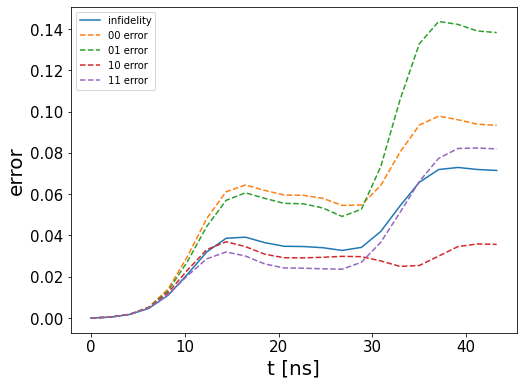

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(twoq_control_eval_times, error_fidel_array, label='infidelity')
plt.plot(twoq_control_eval_times, error_00_array, label='00 error', linestyle='dashed')
plt.plot(twoq_control_eval_times, error_01_array, label='01 error', linestyle='dashed')
plt.plot(twoq_control_eval_times, error_10_array, label='10 error', linestyle='dashed')
plt.plot(twoq_control_eval_times, error_11_array, label='11 error', linestyle='dashed')
ax.tick_params(labelsize=15)
ax.legend()
plt.xlabel('t [ns]', fontsize=20)
plt.ylabel('error', fontsize=20)
plt.show()